Two environments - binary vs. normal

Matched on EV difference and variance

Two levels of EV difference (easy vs. hard)
Two levels of variance (low variance vs. high variance)

In [3]:
from scipy.stats import norm

N_PROBLEMS = 200
X_MIN = -100
X_MAX = 100

MN_MIN = -50 + 20 # adjust for sampling costs
MN_MAX =  30 + 20 # adjust for sampling costs

DIFF_MIN = 5
DIFF_MAX = 20

SD = [5, 20]
VAR = [25, 400]

# Normal condition

In [4]:
arr = []

for sd in SD:
    for i in range(N_PROBLEMS):

        # randomly sample mean of lower option
        MN_A = np.random.randint(MN_MIN, MN_MAX)
        MN_DIFF = np.random.randint(DIFF_MIN, DIFF_MAX)
        MN_B = MN_A + MN_DIFF
        arr.append([MN_A, MN_B, sd**2, sd**2])

problems_normal = pd.DataFrame(arr, columns=['mn_A', 'mn_B', 'var_A', 'var_B'])

In [5]:
problems_normal.head(10)

,mn_A,mn_B,var_A,var_B
0,16,30,25,25
1,-23,-7,25,25
2,15,23,25,25
3,2,12,25,25
4,0,17,25,25
5,10,23,25,25
6,13,32,25,25
7,30,42,25,25
8,-23,-6,25,25
9,5,14,25,25


In [6]:
from sympy.solvers import solve
from sympy import Symbol
from sympy import N

p = Symbol('p')

def solve_match(mn, var, x0):
    p0 = solve(p*((x0-mn)**2) + (1-p)*(((mn-p*x0)/(1-p) - mn)**2) - var, p)
    if len(p0) > 0:
        return N(p0[0])
    else:
        return None
    
def complete_match(mn, p0, x0):
    p1 = 1 - p0
    x1 = (mn - p0*x0)/p1
    return p1, x1

def variance(x0, p0, x1, p1):
    mn = x0*p0 + x1*p1
    return p0*((x0-mn)**2) + p1*((x1-mn)**2)

d = 15
const = 200

In [7]:
arr = []
for i, row in problems_normal.iterrows():
    
    mn_A = row['mn_A']
    mn_B = row['mn_B']
    var_A = row['var_A']
    var_B = row['var_B']
    
    # sample first outcome from uniform distribution
    # around the mean
    done = False
    while not done:

        A_x0 = np.random.randint(mn_A - d, mn_A + d)
        A_p0 = solve_match(mn_A, var_A, A_x0)
        if A_p0 is not None:
            done = True
            A_p1, A_x1 = complete_match(mn_A, A_p0, A_x0)

    done = False
    while not done:
        B_x0 = np.random.randint(mn_B - d, mn_B + d)
        B_p0 = solve_match(mn_B, var_B, B_x0)
        if B_p0 is not None:
            done = True
            B_p1, B_x1 = complete_match(mn_B, B_p0, B_x0)

    A_x0 = int(A_x0)
    A_x1 = int(A_x1)
    B_x0 = int(B_x0)
    B_x1 = int(B_x1)
    mn_A_calc = A_p0*A_x0 + A_p1*A_x1
    var_A_calc = variance(A_x0, A_p0, A_x1, A_p1)
    mn_B_calc = B_p0*B_x0 + B_p1*B_x1
    var_B_calc = variance(B_x0, B_p0, B_x1, B_p1)
            
    arr.append([mn_A, var_A, A_x0, A_x1, float(A_p0), mn_A_calc, var_A_calc, 
                mn_B, var_B, B_x0, B_x1, float(B_p0), mn_B_calc, var_B_calc])
    
problems_binary = pd.DataFrame(arr, columns=['mn_A', 'var_A', 'A_x0', 'A_x1', 'A_p0', 'mn_A_calc', 'var_A_calc',
                                             'mn_B', 'var_B', 'B_x0', 'B_x1', 'B_p0', 'mn_B_calc', 'var_B_calc'])

In [8]:
# constrain range of outcomes
ind = (problems_binary.A_x0 >= X_MIN) & (problems_binary.A_x0 <= X_MAX) & \
      (problems_binary.A_x1 >= X_MIN) & (problems_binary.A_x1 <= X_MAX) & \
      (problems_binary.B_x0 >= X_MIN) & (problems_binary.B_x0 <= X_MAX) & \
      (problems_binary.B_x1 >= X_MIN) & (problems_binary.B_x1 <= X_MAX)
    
problems_binary = problems_binary[ind]

In [9]:
problems_binary['n_positive'] = 1*(problems_binary.mn_A > 0) + 1*(problems_binary.mn_B > 0)

In [31]:
ind = []
for variance in VAR:
    for n_pos in [0, 1, 2]:
        subset = problems_binary[(problems_binary.var_A==variance) & (problems_binary.n_positive==n_pos)]
        sample = np.random.choice(subset.index, size=10, replace=False)
        for i in sample:
            ind.append(i)
ind = np.array(ind)
problems_subset = problems_binary.ix[ind]

ev_random_choice = np.sum(problems_subset.mn_A * .5 + problems_subset.mn_B * .5)
print ev_random_choice

276.0


In [32]:
problems_binary_sel = problems_subset
problems_normal_sel = problems_normal.ix[ind]

In [33]:
problems_binary_sel.head(10)

,mn_A,var_A,A_x0,A_x1,A_p0,mn_A_calc,var_A_calc,mn_B,var_B,B_x0,B_x1,B_p0,mn_B_calc,var_B_calc,n_positive
192,-10,25,-2,-13,0.280899,-9.91011235955056,24.4413584143416,-1,25,0,-26,0.961538,-0.999999999999999,25.0000000000000,0
152,-11,25,-1,-13,0.200000,-10.6000000000000,23.0400000000000,-4,25,-8,2,0.609756,-4.09756097560976,23.7953599048186,0
97,-18,25,-15,-26,0.735294,-17.9117647058824,23.5510380622837,-2,25,-1,-27,0.961538,-2.00000000000000,25.0000000000000,0
85,-26,25,-41,-24,0.100000,-25.7000000000000,26.0100000000000,-19,25,-24,-14,0.500000,-19.0000000000000,25.0000000000000,0
147,-14,25,0,-15,0.113122,-13.3031674208145,22.5732478859974,-9,25,0,-11,0.235849,-8.40566037735849,21.8071377714489,0
28,-22,25,-19,-30,0.735294,-21.9117647058824,23.5510380622837,-10,25,4,-11,0.113122,-9.30316742081448,22.5732478859974,0
124,-9,25,-23,-7,0.113122,-8.80995475113122,25.6833398169571,-2,25,2,-8,0.609756,-1.90243902439024,23.7953599048186,0
101,-19,25,-13,-23,0.409836,-18.9016393442623,24.1870464928783,-14,25,-17,-5,0.735294,-13.8235294117647,28.0276816608997,0
64,-28,25,-42,-26,0.113122,-27.8099547511312,25.6833398169571,-21,25,-15,-25,0.409836,-20.9016393442623,24.1870464928783,0
115,-20,25,-28,-16,0.280899,-19.3707865168539,29.0872364600429,-12,25,-23,-9,0.171233,-11.3972602739726,27.8147870144492,0


In [34]:
problems_normal_sel

,mn_A,mn_B,var_A,var_B
192,-10,-1,25,25
152,-11,-4,25,25
97,-18,-2,25,25
85,-26,-19,25,25
147,-14,-9,25,25
28,-22,-10,25,25
124,-9,-2,25,25
101,-19,-14,25,25
64,-28,-21,25,25
115,-20,-12,25,25


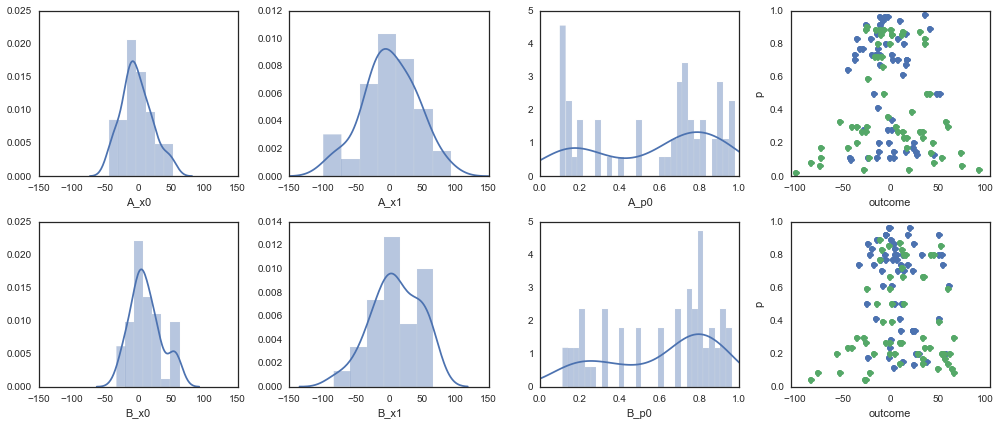

In [35]:
fig, ax = plt.subplots(2, 4, figsize=(14,6))
sns.distplot(problems_binary_sel.A_x0, ax=ax[0][0])
sns.distplot(problems_binary_sel.A_x1, ax=ax[0][1])
sns.distplot(problems_binary_sel.A_p0, 30, ax=ax[0][2])
sns.distplot(problems_binary_sel.B_x0, ax=ax[1][0])
sns.distplot(problems_binary_sel.B_x1, ax=ax[1][1])
sns.distplot(problems_binary_sel.B_p0, 30, ax=ax[1][2])


for axi in ax.ravel():    
    axi.set_xlim(-150,150)
ax[0][2].set_xlim(0,1)
ax[1][2].set_xlim(0,1)

axi = ax[0][3]
axi.plot(problems_binary_sel.A_x0.values,
         problems_binary_sel.A_p0.values, 'o')
axi.plot(problems_binary_sel.A_x1.values,
         1-problems_binary_sel.A_p0.values, 'o')
axi.set_ylim(0,1)
axi.set_xlim(-105,105)
axi.set_xlabel('outcome')
axi.set_ylabel('p')

axi = ax[1][3]
axi.plot(problems_binary_sel.B_x0.values,
         problems_binary_sel.B_p0.values, 'o')
axi.plot(problems_binary_sel.B_x1.values,
         1-problems_binary_sel.B_p0.values, 'o')
axi.set_ylim(0,1)
axi.set_xlim(-105,105)
axi.set_xlabel('outcome')
axi.set_ylabel('p')

plt.tight_layout()
plt.show()
#fig.savefig('/Users/markant/Box Sync/PapersWorking/CHASEExp/options.pdf', bbox_inches='tight')

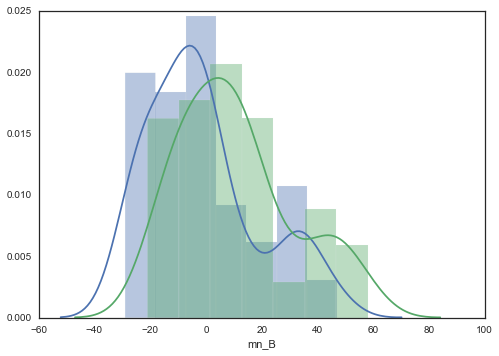

In [36]:
sns.distplot(problems_normal_sel.mn_A)
sns.distplot(problems_normal_sel.mn_B)

# Save

In [37]:
problems_normal_sel['variance'] = ['high' if x==400 else 'low' for x in problems_normal_sel['var_A'].values]
problems_binary_sel['variance'] = ['high' if x==400 else 'low' for x in problems_binary_sel['var_A'].values]
problems_binary_sel['id'] = ['binary-%s' % i for i in range(problems_binary_sel.shape[0])]
problems_normal_sel['id'] = ['normal-%s' % i for i in range(problems_binary_sel.shape[0])]
problems_binary_sel.to_csv('/Users/markant/experiments/exp_chase/chase-v0/static/problems_binary.csv')
problems_normal_sel.to_csv('/Users/markant/experiments/exp_chase/chase-v0/static/problems_normal.csv')

In [214]:
#problems_binary_sel.drop('n_positive', 1, inplace=True)
#problems_normal_sel.drop('n_positive', 1, inplace=True)

In [216]:
problems_binary_sel.head()

,mn_A,var_A,A_x0,A_x1,A_p0,mn_A_calc,var_A_calc,mn_B,var_B,B_x0,B_x1,B_p0,mn_B_calc,var_B_calc,id,variance
60,-39,25,-41,-26,0.862069,-38.9310344827586,26.7538644470868,-23,25,-36,-21,0.128866,-22.9329896907216,25.2583962163886,binary-0,low
179,-39,25,-40,-14,0.961538,-39.0000000000000,25.0000000000000,-28,25,-21,-31,0.337838,-27.6216216216216,22.3703433162893,binary-1,low
43,-45,25,-58,-43,0.128866,-44.9329896907216,25.2583962163886,-27,25,-26,-52,0.961538,-27.0000000000000,25.0000000000000,binary-2,low
54,-30,25,-33,-21,0.735294,-29.8235294117647,28.0276816608997,-17,25,-32,-15,0.100000,-16.7000000000000,26.0100000000000,binary-3,low
110,-20,25,-14,-24,0.409836,-19.9016393442623,24.1870464928783,-2,25,8,-4,0.200000,-1.60000000000000,23.0400000000000,binary-4,low


In [217]:
problems_normal_sel.head()

,mn_A,mn_B,var_A,var_B,id,variance
60,-39,-23,25,25,normal-0,low
179,-39,-28,25,25,normal-1,low
43,-45,-27,25,25,normal-2,low
54,-30,-17,25,25,normal-3,low
110,-20,-2,25,25,normal-4,low
